In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, palette='pastel')
%matplotlib inline
from collections import defaultdict
from scipy.stats import entropy
import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
out_path = '../data/2017-09-28/'

data = pd.read_csv('../data/2017-09-28/enrichment.csv', index_col=0) # read in our data
column_names = { l.split()[0].strip() : l.split()[1].strip() 
                for l in open('../data/2017-09-28/samples.tsv', 'r')} # pull primate serum data from file
column_names['Peptide_sequence'] = 'sequence'
data.rename(columns = column_names, inplace=True) # relabel columns by exposure
data.drop(['start.1', 'end.1', 'beads', 'input', 'CONTROL'], axis=1, inplace=True) # drop duplicate or uninformative columns

autologous_strains = { l.split(',')[0].strip() : l.split(',')[1].strip() # pull innoculate strain data from file
                      for l in open('../docs/innoculation_strains.csv', 'r').readlines()}

metadata_cols = ['virus', 'start', 'end', 'sequence', 'strains'] # nonnumeric columns
sample_cols = [c for c in data.columns.values if c not in metadata_cols] # data columns

print data.head() # peek at the first few rows

           ZIKV     DENV2     DENV4     CHIKV     DENV3     DENV1       YFV  \
id                                                                            
1      0.714068  1.133519  0.417436  0.860274  0.628005  4.819417  0.531971   
2      0.485121  0.292050  0.791965  0.892818  0.657400  6.201722  1.315439   
3.188  0.727847  0.464419  0.628870  0.393842  0.414503  1.216171  1.568620   
4.189  0.668454  0.757510  0.529607  0.755118  0.950584  1.034301  0.138424   
5.19   0.732607  1.226857  0.962813  0.774894  0.020467  0.239267  0.021250   

       virus  start  end                                 sequence  \
id                                                                  
1      CHIKV      1  118  MDPVYVDIDADSAFLKALQRAYPMFEVEPRQVTPNDHAN   
2      CHIKV     61  178  AYPMFEVEPRQVTPNDHANARAFSHLAIKLIEQEIDPDS   
3.188  CHIKV    121  238  RAFSHLAIKLIEQEIDPDSTILDIGSAPARRMMSDRKYH   
4.189  CHIKV    181  298  ILDIGSAPARRMMSDRKYHCVCPMRSAEDPERLANYARK   
5.19   CHIKV    241  358  VCPMRS

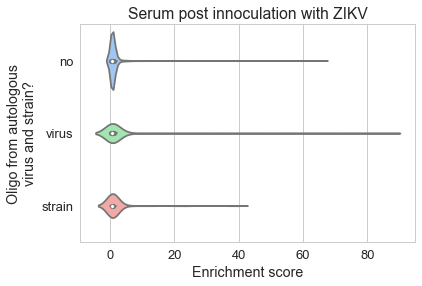

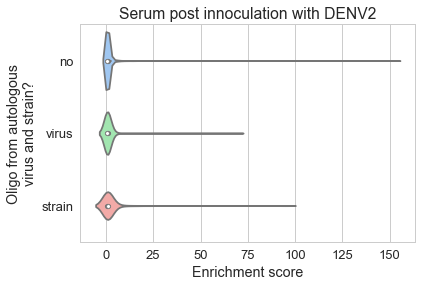

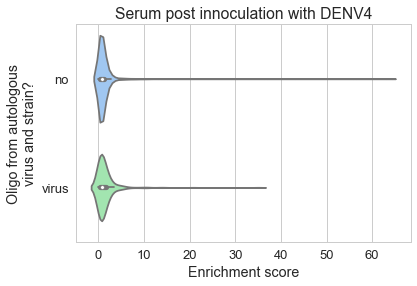

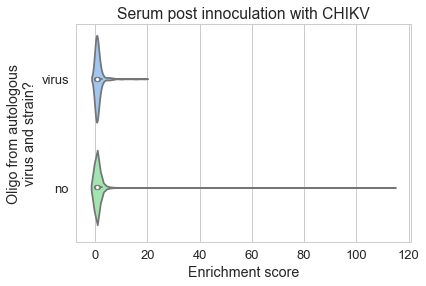

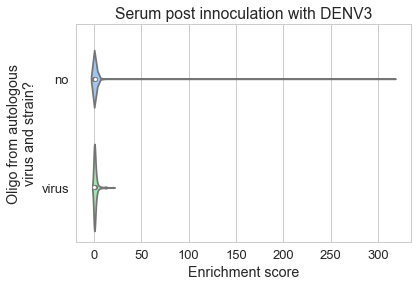

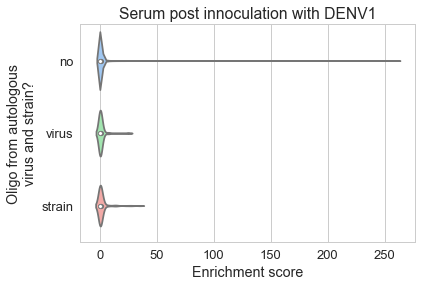

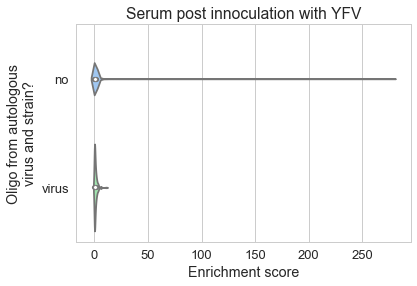

In [3]:
def get_autologous_serum(serum, df):
    ''' for a given serum sample, return a categorical series indicating whether 
    each oligo in the dataframe is from an autologous virus and/or strain'''
    autologous_strain = autologous_strains[serum].upper()
    autologous_virus = serum
    
    def is_autologous(row):
        if row['virus'] == autologous_virus and autologous_strain in row['strains']:
            return 'strain'
        elif row['virus'] == autologous_virus: # strain not autologous but virus is
            return 'virus'
        else: # totally different virus
            return 'no'
    
    autologous = df.apply(is_autologous, axis=1) # map to every row in the dataframe
    return autologous # return series (the index values here are the same in the original df, so they can be matched up later)

def plot_sera_distrib(serum, df):
    autologous = get_autologous_serum(serum, df) # categorize oligos by autologous-ness at virus and strain level
    ax = sns.violinplot(df[serum], autologous) # plot distribution of enrichment scores from each category
    ax.set_ylabel('Oligo from autologous\nvirus and strain?')
    ax.set_xlabel('Enrichment score')
    ax.set_title('Serum post innoculation with '+serum)
    plt.show()
    plt.close()
    
for serum in sample_cols:
    plot_sera_distrib(serum, data)

In [75]:
def calc_entropy(row):
#     total = row[sample_cols].sum()
    total = row.sum()
    if total == 0:
        return 0.
#     distrib = row[sample_cols].map(lambda x: float(x) / float(total))
    distrib = row.map(lambda x: float(x) / float(total))

    return entropy(distrib.values)

# data['entropy'] = data.apply(calc_entropy, axis=1)
# data['max_enrichment'] = data[sample_cols].max(axis=1)

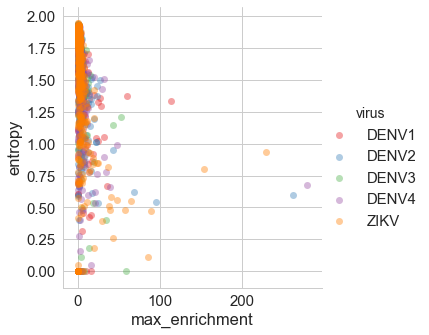

In [68]:
sns.set(style='whitegrid', palette="Set1", font_scale=1.5)
flavivirus_oligos = data.loc[data['virus'].isin(['DENV1', 'DENV2', 'DENV3', 'DENV4', 'ZIKV'])]
ax = sns.lmplot(x='max_enrichment', y='entropy', hue='virus', data=flavivirus_oligos, fit_reg=False, scatter_kws={'alpha': 0.4})
# ax.set_xlabel('Max enrichment score')
# ax.set_ylabel('Entropy')
# ax.set_ylim(0,2.5)

In [80]:
uniform_distrib = [ 1./50. for i in range(50) ]
normal_distrib = [np.random.normal() for i in range(50)]
exponential_distrib = [ np.random.exponential() for i in range(50)]

print calc_entropy(pd.Series(uniform_distrib))
print calc_entropy(pd.Series(normal_distrib))
print calc_entropy(pd.Series(exponential_distrib))

3.91202300543
-inf
3.44357230664


In [81]:
def find_all_oligos(virus, site, data=data):
    '''
    find all the integer indices 
    in the dataframe that correspond to oligos 
    containing that site
    '''
    indices = np.where((data['virus']==virus) &
                 (data['start'] <= site) & 
                 (site <= data['end']))
    return indices[0]
    
def aggregate_site(virus, site, data):
    '''Return a series of the mean value of each column for all oligos containing the input site'''
    indices = find_all_oligos(virus, site, data)
    entries = data.iloc[indices]
    agg = entries.mean(axis=0)
    return agg
        
def aggregate_virus_sites(virus, data=data):
    ''' For all sites in the viral genome in the dataset, fetch the aggregated values of all oligos containing that site'''
    first_site = data.loc[data['virus'] == virus]['start'].min()
    last_site = data.loc[data['virus']==virus]['end'].max()
    
    sites = range(first_site, last_site)
    aggregated_sites = { site: aggregate_site(virus, site, data) for site in sites }

    df = pd.DataFrame.from_dict(aggregated_sites, orient='index')
    df.to_csv(out_path + virus + '_sitewise_enrichment.csv')
    return df

site_maps = {virus: aggregate_virus_sites(virus) for virus in pd.unique(data['virus'])}

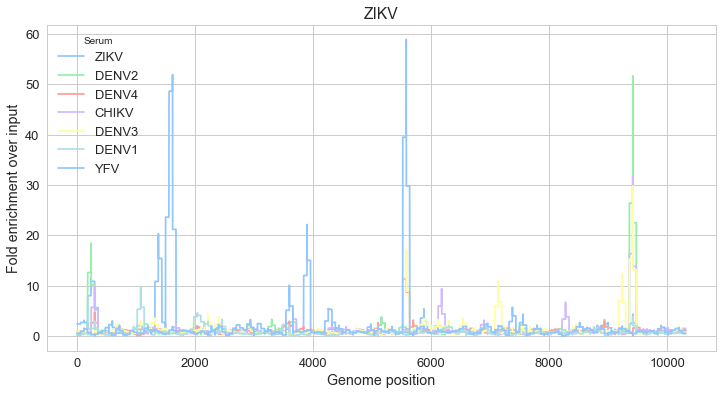

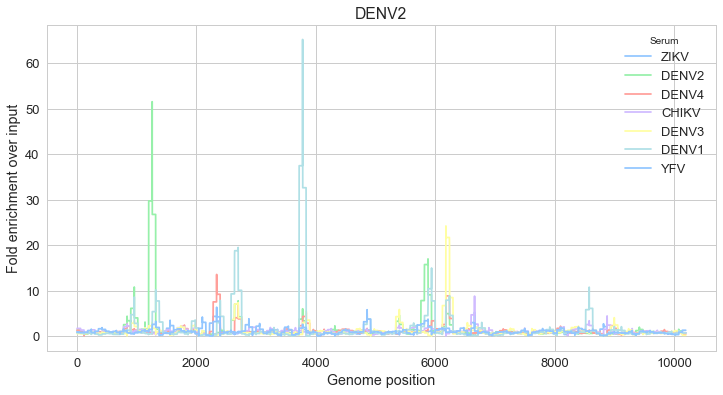

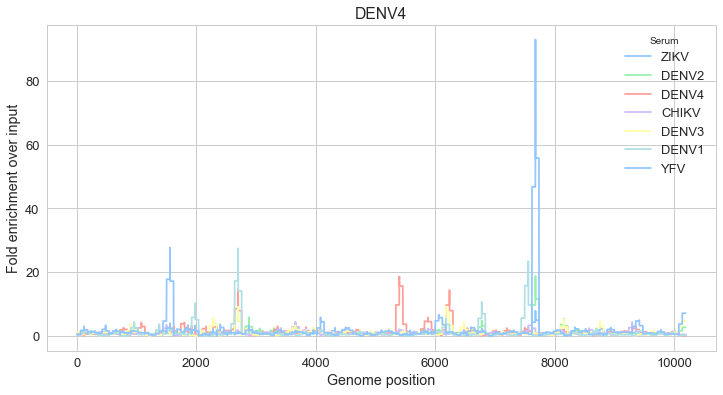

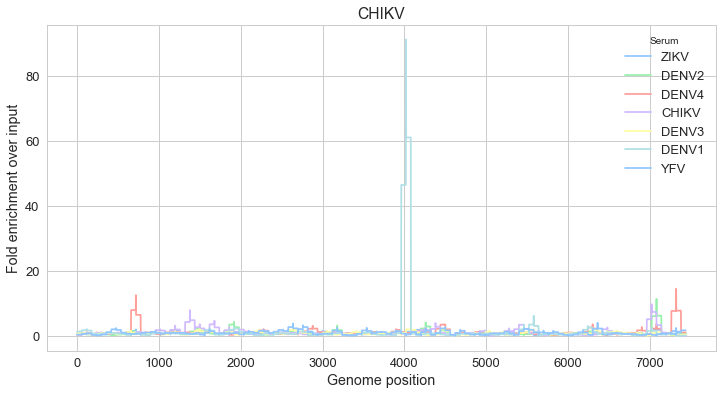

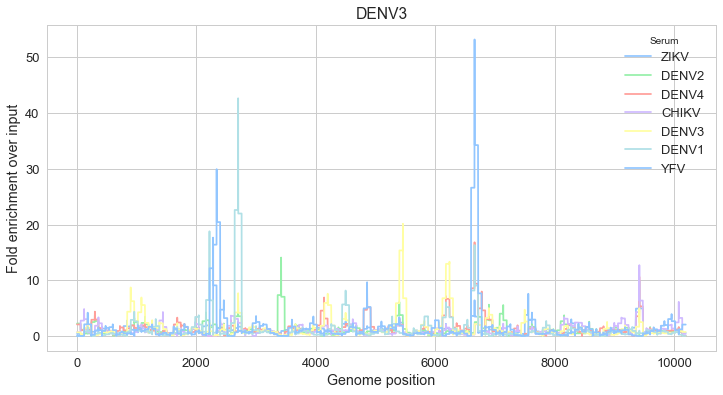

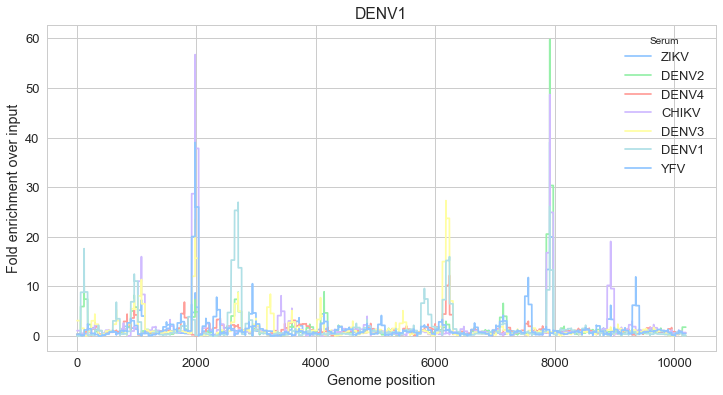

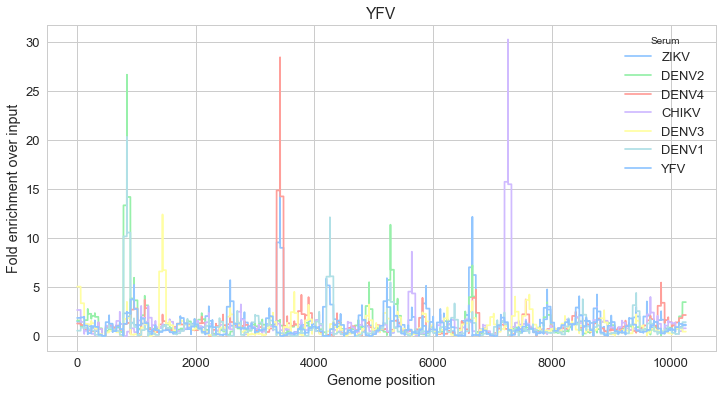

In [29]:
def plot_binding_footprint(virus, serum, ax=None):
    
    values = site_maps[virus][serum]
    
    if ax == None:
        fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(values.index.values, values.values, label=serum)
    return ax

def plot_all_binding_footprints(virus):
    values = site_maps[virus]
    
    fig, ax = plt.subplots(figsize=(12,6))
    for serum in sample_cols:
        plot_binding_footprint(virus, serum, ax)
    plt.legend(title='Serum')
    ax.set_title(virus)
    ax.set_xlabel('Genome position')
    ax.set_ylabel('Fold enrichment over input')
    plt.show()
        
for virus in sample_cols:
    plot_all_binding_footprints(virus)

In [91]:
def plot_interactive_binding_footprints(virus):
    values = site_maps[virus]
    traces = []
    
    for serum in ['DENV1', 'DENV2', 'DENV3', 'DENV4', 'ZIKV']:
        vals = values[serum]
        
        trace = go.Scatter(
            x = vals.index.values,
            y = vals.values,
            mode = 'lines',
            name = serum)
        
        traces.append(trace)
    
    layout = dict(title = 'Oligos from %s'%virus,
              xaxis = dict(title = 'Genomic position'),
              yaxis = dict(title = 'Fold enrichment by sera'),
              )
    
    py.iplot(traces, filename=virus)


for virus in sample_cols:
    plot_interactive_binding_footprints(virus)

The draw time for this plot will be slow for clients without much RAM.
The draw time for this plot will be slow for clients without much RAM.
The draw time for this plot will be slow for clients without much RAM.
The draw time for this plot will be slow for clients without much RAM.
The draw time for this plot will be slow for clients without much RAM.
The draw time for this plot will be slow for clients without much RAM.
The draw time for this plot will be slow for clients without much RAM.
